# Generic Engine Pipeline

The notebook provides a generic end-to-end model training pipeline for experimentation.

The notebook works by configuring the input data set and uses a disk caching method to cache function calls to speed up model training.

Unlike prior work on Project Echo, no offline pre-processing of the audio files is required (this is encapsulted in the processing pipeline within this notebook).

Author: akudilczak

In [1]:
########################################################################################
# library imports
########################################################################################

# disable warnings
import warnings
warnings.filterwarnings("ignore")

# generic libraries
from platform import python_version
import functools
import inspect
from collections import deque
import diskcache as dc
import hashlib
import numpy as np
import os
import datetime
import random
import matplotlib.pyplot as plt

# tensor flow / keras related libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
from keras.utils import dataset_utils

# image processing related libraries
import librosa 

# audio processing libraries
import audiomentations
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('TensorFlow IO Version    : ', tfio.__version__)
print('Librosa Version          : ', librosa.__version__)
print('Audiomentations Version  : ', audiomentations.__version__)

Python Version           :  3.8.16
TensorFlow Version       :  2.10.1
TensorFlow IO Version    :  0.27.0
Librosa Version          :  0.9.2
Audiomentations Version  :  0.29.0


## System Configuration

The following code sets up the pipeline with configuration options.

The key is to set the audio data directory to the root directory containing the folders with raw audio files. 

This expects the folders names to be the species names.  

In [2]:
########################################################################################
# system constants
########################################################################################

SC = {
    'AUDIO_DATA_DIRECTORY': "d:\\data\\bc",
    'CACHE_DIRETORY': "d:\\pipeline_cache",

    'AUDIO_NFFT': 1024,
    'AUDIO_WINDOW': 512,
    'AUDIO_STRIDE': 256,
    'AUDIO_SAMPLE_RATE': 32000,  # int(44100/2)
    'AUDIO_MELS': 256,
    'AUDIO_FMIN': 0,
    'AUDIO_FMAX': int(32000 / 2),
    'AUDIO_TOP_DB': 80,

    'MODEL_INPUT_IMAGE_WIDTH': 384,
    'MODEL_INPUT_IMAGE_HEIGHT': 384,
    'MODEL_INPUT_IMAGE_CHANNELS': 3,

    'USE_DISK_CACHE': True,
    'SAMPLE_VARIANTS': 40,
    'CLASSIFIER_BATCH_SIZE': 8
}

# Disk Caching

The following code creates a disk cache.  You will need lots of space (20 GB+) if you create large melspectrograms.

The caching works by serialising a function call signature and hashing it into a key.  This key is used to store the result of the function call.

This allows the a result from the cache to be utilised instead of calling the function, which means the entire data processing pipeline can be cached if used correctly.

This works best when the function being cached is idempotent.  There may be circumstances where it doesn't matter.  Be careful with using this cache as you may get unexpected results.

In [3]:
########################################################################################
# Create a DiskCache instance
# This cache will allow us store intermediate function results to speed up the 
# data processing pipeline
########################################################################################
cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 


########################################################################################
# a helper function to create a hash key from a function signature and arguments
########################################################################################
def create_function_key(func, *args, **kwargs):
    partial_func = functools.partial(func, *args, **kwargs)
    func_name = partial_func.func.__name__
    func_module = partial_func.func.__module__
    args_repr = repr(partial_func.args)
    kwargs_repr = repr(sorted(partial_func.keywords.items()))

    key = f"{func_module}.{func_name}:{args_repr}:{kwargs_repr}"
    # Use hashlib to create a hash of the key for shorter and consistent length
    key_hash = hashlib.sha256(key.encode()).hexdigest()

    return key, key_hash, partial_func


########################################################################################
# Execute a function and cache the result
# If already executed, retrieve function output from the cache instead
########################################################################################
def execute_cached_function(func, *args, **kwargs):
    key_string,key,partial_func = create_function_key(func, *args, **kwargs)
    # Check if the result is in the cache
    if key in cache:
        result = cache[key]
        # print(f"Result loaded from cache key: {key}")
    else:
        # If not in cache, call the slow operation and store the result in cache
        result = partial_func()
        cache[key] = result
        #print(f"New result calculated and stored in cache key: {key}")
    return result

# Loading the files into a Tensorflow dataset structure for model training

This initial code loads only the filenames.  The filenames are then split into train, validation and test datasets.  This is designed deliberately this way to conserve runtime memory.

Subsequent downstream loading of the file content occurs as part of the data pipeline transformation 'map' function.  See below.

In [4]:
########################################################################################
# these helper functions load the audio data into a 'dataset' using only paths
# just dealing with paths at this early stage means the entire dataset can be shuffled in
# memory and split before loading the actual audio data into memory
########################################################################################
def paths_and_labels_to_dataset(image_paths, labels, num_classes):
    path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    label_ds = dataset_utils.labels_to_dataset(
        labels, 
        'categorical', 
        num_classes)
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    return zipped_path_ds

def create_datasets(audio_files, train_split=0.7, val_split=0.2):
    file_paths, labels, class_names = dataset_utils.index_directory(
            audio_files,
            labels="inferred",
            formats=('.ogg','.mp3','.wav','.flac'),
            class_names=None,
            shuffle=False,
            seed=42,
            follow_links=False)

    dataset = paths_and_labels_to_dataset(
        image_paths=file_paths,
        labels=labels,
        num_classes=len(class_names))
    
    # Calculate the size of the dataset
    dataset_size = len(dataset)
    
    # Calculate the number of elements for each dataset split
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)
    test_size = dataset_size - train_size - val_size

    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)

    # Split the dataset
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size + val_size).take(test_size)
    
    return train_ds, val_ds, test_ds, class_names

In [5]:
# create the dataset
train_ds, val_ds, test_ds, class_names = create_datasets(SC['AUDIO_DATA_DIRECTORY'],train_split=0.8, val_split=0.19)
print("Class names: ", class_names)
print(f"Training   dataset length: {len(train_ds)}")
print(f"Validation dataset length: {len(val_ds)}")
print(f"Test       dataset length: {len(test_ds)}")

Found 524 files belonging to 5 classes.
Class names:  ['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur']
Training   dataset length: 419
Validation dataset length: 99
Test       dataset length: 6


In [6]:
# show what the pipeline looks like at this stage
for item in train_ds.take(10):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\sheowl\\XC666501.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\wiltur\\XC317966.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\wiltur\\XC618595.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 0., 0., 1.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\brant\\XC540354.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 0., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\sheowl\\XC295378.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 0., 1., 0., 0.], dtype=float32)>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'd:\\data\\bc\\spodov\\XC443310.ogg'>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0

In [7]:
def load_random_subsection(path, duration_secs):

    # read the file data
    file_contents=tf.io.read_file(path)

    # attempt to decode each known format
    try:
        tmp_audio_t = tfio.audio.decode_flac(input=file_contents)
    except:
        pass

    try:
        tmp_audio_t = tfio.audio.decode_vorbis(input=file_contents)
    except:
        pass
    
    try:
        tmp_audio_t = tfio.audio.decode_mp3(input=file_contents)
    except:
        pass
    
    try:
        tmp_audio_t = tfio.audio.decode_wav(input=file_contents)
    except:
        pass

    # cast and keep left channel only
    tmp_audio_t = tf.cast(tmp_audio_t, tf.float32)[:,-1]
    
    # resample the sample rate
    tmp_audio_t = tfio.audio.resample(tmp_audio_t, tfio.audio.AudioIOTensor(path)._rate.numpy(), SC['AUDIO_SAMPLE_RATE'])

    # Determine the audio file's duration in seconds
    audio_duration_secs = tf.shape(tmp_audio_t)[0] / SC['AUDIO_SAMPLE_RATE']
    
    if audio_duration_secs>duration_secs:
    
        # Calculate the starting point of the 5-second subsection
        max_start = tf.cast(audio_duration_secs - duration_secs, tf.float32)
        start_time_secs = tf.random.uniform((), 0.0, max_start, dtype=tf.float32)
        
        start_index = tf.cast(start_time_secs * SC['AUDIO_SAMPLE_RATE'], dtype=tf.int32)
  
        # Load the 5-second subsection
        end_index = tf.cast(start_index + tf.cast(duration_secs, tf.int32) * SC['AUDIO_SAMPLE_RATE'], tf.int32)
        
        subsection = tmp_audio_t[start_index : end_index]
    
    else:
        # Pad the subsection with silence if it's shorter than 5 seconds
        padding_length = duration_secs * SC['AUDIO_SAMPLE_RATE'] - tf.shape(tmp_audio_t)[0]
        padding = tf.zeros([padding_length], dtype=tmp_audio_t.dtype)
        subsection = tf.concat([tmp_audio_t, padding], axis=0)

    return subsection

In [8]:
# audio augmentation pipeline
# see https://github.com/iver56/audiomentations for more options
audio_augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])

In [9]:
def dataset_melspectro_pipeline(path, label, variant, config, audio_clip):
    
    # Convert to spectrogram
    image = tfio.audio.spectrogram(
        audio_clip,
        nfft=config['AUDIO_NFFT'], 
        window=config['AUDIO_WINDOW'], 
        stride=config['AUDIO_STRIDE'])
    
    # Convert to melspectrogram
    image = tfio.audio.melscale(
        image, 
        rate=config['AUDIO_SAMPLE_RATE'], 
        mels=config['AUDIO_MELS'], 
        fmin=config['AUDIO_FMIN'], 
        fmax=config['AUDIO_FMAX'])
    
    # reshape into standard 3 channels to add the color channel
    image = tf.expand_dims(image, -1)
    
    # most pre-trained model classifer model expects 3 color channels
    image = tf.repeat(image, config['MODEL_INPUT_IMAGE_CHANNELS'], axis=2)
    
    image = tf.ensure_shape(image, [625, config['AUDIO_MELS'], config['MODEL_INPUT_IMAGE_CHANNELS']])
    image = tf.image.resize(image, (config['MODEL_INPUT_IMAGE_WIDTH'],config['MODEL_INPUT_IMAGE_HEIGHT']), 
                            method=tf.image.ResizeMethod.LANCZOS5)

    # rescale to range [0,1]
    image = image - tf.reduce_min(image) 
    image = image / (tf.reduce_max(image)+0.0000001)
    
    return image, label

def dataset_validation_pipeline(path, label, variant, config):
    # print(f'processing path {path} variant {variant}')
    
    # this loads a random 5 second clip of audio from the raw audio file
    # note: it also converts the sample rate to AUDIO_SAMPLE_RATE and selects the left channel only
    audio_clip = load_random_subsection(path, duration_secs=5)

    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    return image, label

def dataset_test_pipeline(path, label, variant, config):
    # print(f'processing path {path} variant {variant}')
    
    # this loads a random 5 second clip of audio from the raw audio file
    # note: it also converts the sample rate to AUDIO_SAMPLE_RATE and selects the left channel only
    audio_clip = load_random_subsection(path, duration_secs=5)

    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    return image, label

def dataset_training_pipeline(path, label, variant, config):
    
    # print(f'processing path {path} variant {variant}')
    
    # this loads a random 5 second clip of audio from the raw audio file
    # note: it also converts the sample rate to AUDIO_SAMPLE_RATE and selects the left channel only
    audio_clip = load_random_subsection(path, duration_secs=5)
   
    # apply audio augmentation to the clip
    # note: this augmentation is NOT applied in the test and validation pipelines
    audio_clip = audio_augment(samples=audio_clip.numpy(), sample_rate=config['AUDIO_SAMPLE_RATE'])
   
    # Convert to spectrogram
    image, label = dataset_melspectro_pipeline(path, label, variant, config, audio_clip)
    
    return image, label

def dataset_cached_pipeline(pipeline_fn, path, label):
    variant = random.randrange(0, SC['SAMPLE_VARIANTS'])
    if SC['USE_DISK_CACHE']:
        return execute_cached_function(pipeline_fn,path,label,variant,SC)
    else:
        return pipeline_fn(path,label,variant,SC)

In [10]:
# this will allow python execution within the tensorflow pipeline
def dataset_pipeline_wrapper(pipeline_fn, path, label):
    # Use a lambda function to pass two arguments to the dataset_example_pipeline function
    image, label = tf.py_function(func=lambda x, y: dataset_cached_pipeline(pipeline_fn, x, y), inp=(path, label), Tout=(tf.float32, label.dtype))

    # Set the shape of the output tensors manually
    image.set_shape([SC['MODEL_INPUT_IMAGE_WIDTH'], SC['MODEL_INPUT_IMAGE_HEIGHT'], SC['MODEL_INPUT_IMAGE_CHANNELS']])
    label.set_shape([len(class_names),])  # Set the shape of the label tensor

    return image, label

In [11]:
########################################################################################
# create the datasets useful for training a classification model
########################################################################################
train_dataset = (train_ds
                 .map(functools.partial(dataset_pipeline_wrapper, dataset_training_pipeline), num_parallel_calls=1)
                 .batch(SC['CLASSIFIER_BATCH_SIZE'])
                 .repeat(count=5)         
)

validation_dataset = (val_ds
                      .map(functools.partial(dataset_pipeline_wrapper, dataset_validation_pipeline), num_parallel_calls=1)
                      .batch(SC['CLASSIFIER_BATCH_SIZE'])
                      .repeat(count=2)
)

test_dataset = (test_ds
                .map(functools.partial(dataset_pipeline_wrapper, dataset_test_pipeline), num_parallel_calls=1)
                .batch(SC['CLASSIFIER_BATCH_SIZE'])
                .repeat(count=5)  
)

 sample info: (8, 384, 384, 3), [[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


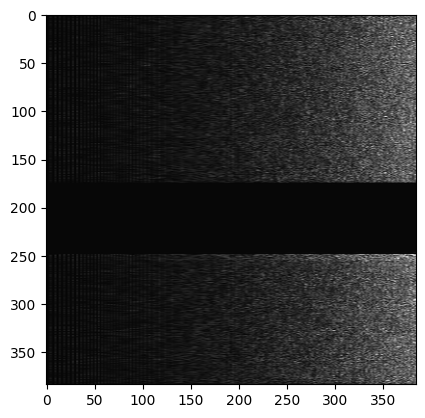

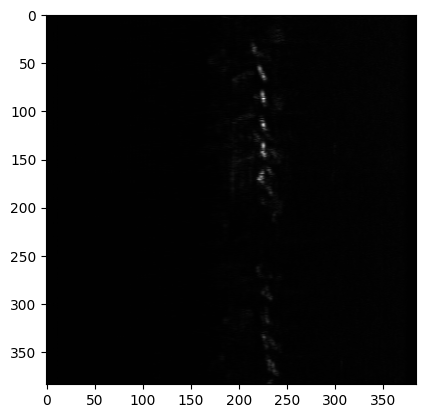

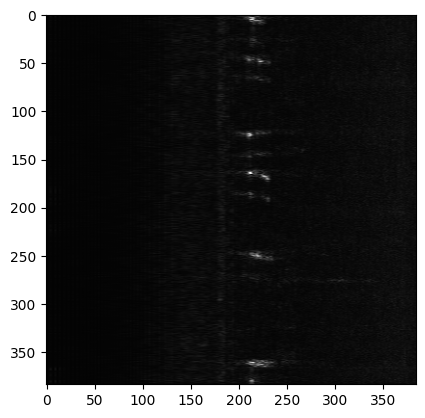

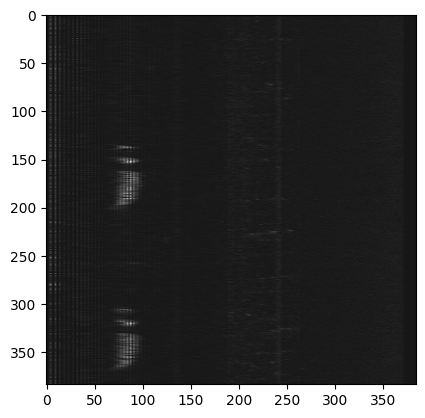

In [12]:
# show what the pipeline looks like at this stage
for melspectrogram,label in train_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, {label}')
    plt.imshow(melspectrogram[0,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[2,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[3,:,:,:], cmap='afmhot')
    plt.show()
    plt.imshow(melspectrogram[4,:,:,:], cmap='afmhot')
    plt.show()

In [13]:
def build_model(trainable):
    # build a really simple classification model using a pre-training Efficientnet V2
    model = tf.keras.Sequential(
        [
            # input layer
            tf.keras.layers.InputLayer(input_shape=(SC['MODEL_INPUT_IMAGE_HEIGHT'], 
                                                    SC['MODEL_INPUT_IMAGE_WIDTH'], 
                                                    SC['MODEL_INPUT_IMAGE_CHANNELS'])),
  
            # use the model as a feature generator only
            hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2", trainable), 
                     
            # add the classification layer here       
            tf.keras.layers.Flatten(), 
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*3, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dense(len(class_names)*2, 
                                  activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.L1(1e-2)),
            tf.keras.layers.BatchNormalization(),
            
            tf.keras.layers.Dropout(0.50),
            tf.keras.layers.Dense(len(class_names)*1, activation=None),
        ]
    )
    # need to tell the model what the input shape is
    model.build([None, 
                 SC['MODEL_INPUT_IMAGE_HEIGHT'],
                 SC['MODEL_INPUT_IMAGE_WIDTH'], 
                 SC['MODEL_INPUT_IMAGE_CHANNELS']])

    # show the model
    model.summary()
    
    return model

In [14]:
if not os.path.exists('models/'):
    os.mkdir('models/')
    
# allow all the weights to be trained
model = build_model(True)

# the form_logits means the loss function has the 'softmax' buillt in.  This approach is numerically more stable
# than including the softmax activation on the last layer of the classifier
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3), 
              metrics=["accuracy"],
              )

# tensorboard for visualisation of results
log_dir = "tensorboard_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=1)

# reduce learning rate to avoid overshooting local minima
lr_reduce_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                      factor=0.75,
                                                      patience=20, 
                                                      verbose=1,
                                                      mode='min',
                                                      cooldown=0, 
                                                      min_lr=1e-8)

# end the training if no improvement for 16 epochs in a row, then restore best model weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=30,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

# save the best model as it trains..
mcp_save = tf.keras.callbacks.ModelCheckpoint('models/checkpoint_generic_model.hdf5', 
                                           save_best_only=True, 
                                           monitor='val_loss', 
                                           mode='min')

# any changes to the source code will generally require the disk cache to be cleared.
# So to be safe, the cache is cleared before training the model.  If you are sure
# the cache is still valid then comment out this code
# the first few epochs of the model training will be slow as the cache is populated with pipeline samples
# and will depend on the dataset size and the number of variants included
# cache.clear()

# fit the model to the training set
model.fit(train_dataset, 
          validation_data=validation_dataset,
          callbacks=[lr_reduce_plateau, early_stopping, tensorboard_callback, mcp_save],
          epochs=1000)      

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
 batch_normalization_1 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                1

  4/265 [..............................] - ETA: 1:12 - loss: 9.1704 - accuracy: 0.2500WARNING:tensorflow:6 out of the last 6 calls to <function pfor.<locals>.f at 0x00000193A27DB0D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


265/265 [==============================] - 345s 1s/step - loss: 5.6166 - accuracy: 0.2148 - val_loss: 4.0682 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 2/1000
265/265 [==============================] - 297s 1s/step - loss: 2.8525 - accuracy: 0.2286 - val_loss: 2.4408 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 3/1000
265/265 [==============================] - 301s 1s/step - loss: 2.3753 - accuracy: 0.2377 - val_loss: 2.2120 - val_accuracy: 0.2848 - lr: 0.0010
Epoch 4/1000
265/265 [==============================] - ETA: 0s - loss: 2.2269 - accuracy: 0.2239

In [ ]:
# save the model weights
model.save_weights('models/generic_engine_pipeline_model.hdf5', save_format='h5')

# test load the model for inference
test_model = build_model(False)
test_model.build([None, 
                SC['MODEL_INPUT_IMAGE_HEIGHT'],
                SC['MODEL_INPUT_IMAGE_WIDTH'], 
                SC['MODEL_INPUT_IMAGE_CHANNELS']])
test_model.load_weights('models/generic_engine_pipeline_model.hdf5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 flatten_3 (Flatten)         (None, 1280)              0         
                                                                 
 batch_normalization_9 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 15)                19215     
                                                                 
 batch_normalization_10 (Bat  (None, 15)               60        
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 10)               

ValueError: Weight count mismatch for layer #0 (named keras_layer_3 in the current model, keras_layer in the save file). Layer expects 670 weight(s). Received 961 saved weight(s)